# Imports, Hardware Parameters & Global Configuration

In [1]:
#Astro-specific
from astropy.io import fits #For working with FITS files
from astropy.modeling import models, fitting #For fitting a 2D Gaussian

#General functions
import numpy as np #Calculations
from scipy import stats #For regressions and confidence intervals
import os #File operations

#Utilities
import matplotlib.pyplot as plt #Plotting
import tqdm #Progress bars
import concurrent.futures #Parallel processing


#User-defined

num_cores = 8 #Maximal number of cores to use for parallel processing. Set to 1 to disable parallel processing.

# Speckle Imaging

In [19]:
#Parameters:
#Directory with the data files
datadir = '../Data/2024-05-09/ZetHer/ShortExp'

#Directory with the dark files (Used here are the bias frames used to measure the readout noise)
darkdir = '../Data/2024-03-19/BiasVSGain/'

#Path to result file
#resultfile = '../Data/2024-05-09/Alkaid/result.fits'

#Gain used for the light frames
gain = 4030

#Percentage of pictures to keep
percentage = 0.05

#Coordinates offset of the subframe
#   Full frame: 11664x8750

x_offset = 5800
y_offset = 4155

In [20]:
#List the data files
datafiles = os.listdir(datadir)

#Determine the shape of the frames
with fits.open(datadir + '/' + datafiles[0]) as hdul:
    height = hdul[0].header['NAXIS2']
    width = hdul[0].header['NAXIS1']

#Create a master dark
#List the darks
darkfiles = []
for i in range(5):
    darkfiles.append('BiasGain' + str(gain) + '_000' + str(i) + '.fits')
datadark = np.zeros((len(darkfiles), height, width))

#Read the dark files
for i, filename in tqdm.tqdm(enumerate(darkfiles), total=len(darkfiles)):
    with fits.open(darkdir + filename) as hdul:
        datadark[i] = hdul[0].section[y_offset:y_offset+height, x_offset:x_offset+width]

#Create the master dark
masterDark = np.median(datadark, axis=0)

#Empty data array to save memory
del datadark

100%|██████████| 5/5 [00:00<00:00, 114.56it/s]


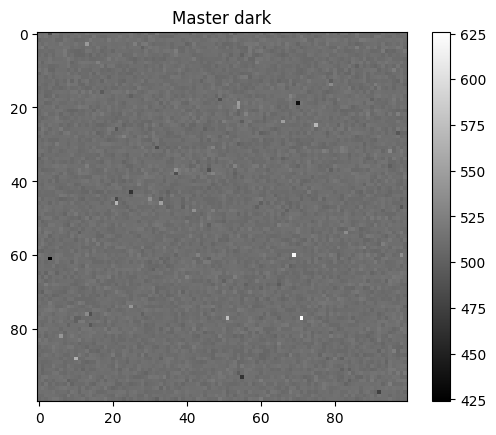

In [21]:
plt.imshow(masterDark, cmap='gray')
plt.colorbar()
plt.title('Master dark')
plt.show()

In [22]:
#Read in the data, own cell for runtime reasons

#Array to store the data
data = np.empty((len(datafiles), height, width))

#Read in the data
for i, filename in tqdm.tqdm(enumerate(datafiles), total=len(datafiles)):
    with fits.open(datadir + '/' + filename) as hdul:
        data[i] = hdul[0].data - masterDark

#Ensure no negative or zero values
data = data.clip(min=1)

100%|██████████| 32767/32767 [00:29<00:00, 1121.62it/s]


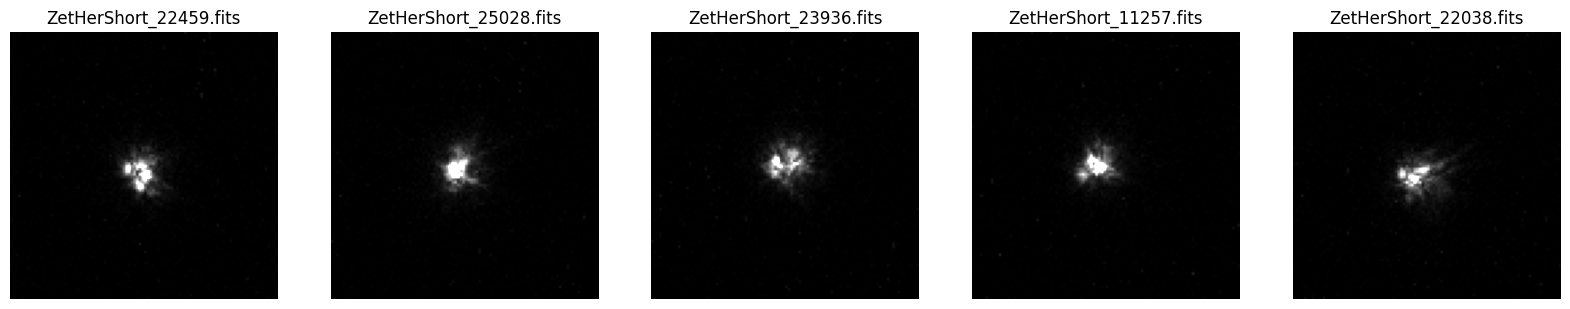

In [24]:
#Show some random images

indices = np.random.choice(len(data), 5, replace=False)

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
maxval = 0.3*np.max(data[indices])

for i, ax in enumerate(axs):
    ax.imshow(data[indices[i]], cmap='gray', vmin=1, vmax=maxval)
    ax.set_title(datafiles[indices[i]])
    ax.axis('off')

plt.show()

In [25]:
def fit_stddev(model, fitter, data, index=0, keepFit=False):
    '''Fits a 2D Gaussian to the data and returns the sum of the standard deviations in x and y directions.'''

    x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
    p_init = model
    p_fit = fitter(p_init, x, y, data)
    if keepFit:
        return np.mean((p_fit.x_stddev.value, p_fit.y_stddev.value)), index, p_fit
    return np.mean((p_fit.x_stddev.value, p_fit.y_stddev.value)), index

In [26]:
#If already ran at some point, you can also load the data from a file
#Evaluate the "goodness" of the data: still problematic
model = models.Gaussian2D(amplitude=2000, x_mean=width/2, y_mean=height/2, x_stddev=10, y_stddev=10, theta=0) #Initial guess
fitter = fitting.LevMarLSQFitter()
stddevs = np.empty(len(data))

# Choose whether to use parallel processing or not. Useful for debugging.
parProc = True
# Choose whether to keep the full fit or just the standard deviation. Useful for debugging.
keepFit = True

if keepFit:
    p_fits = np.empty(len(data), dtype=object)

if parProc and num_cores > 1:  
    #Parallel processing
    with concurrent.futures.ProcessPoolExecutor(num_cores) as executor:
        results = [executor.submit(fit_stddev, model, fitter, data[i], i, keepFit) for i in range(len(data))] #Submit all tasks
        for result in tqdm.tqdm(concurrent.futures.as_completed(results), total=len(data)): #As each task finishes
            stddevs[result.result()[1]] = result.result()[0] #Save the result in the correct index
            if keepFit: p_fits[result.result()[1]] = result.result()[2] #Save the fit for debugging

else:
    #Serial processing
    for i in tqdm.tqdm(range(9530,len(data))): #Start wherever you want for debugging
        x, y = np.meshgrid(np.arange(data[i].shape[1]), np.arange(data[i].shape[0]))
        p_init = model
        p_fit = fitter(p_init, x, y, data[i])
        stddevs[i] = np.mean((p_fit.x_stddev.value, p_fit.y_stddev.value))
        if keepFit: p_fits[i] = p_fit #May be useful for debugging


100%|██████████| 32767/32767 [02:52<00:00, 189.95it/s]


In [27]:
#Optional: Save the results to disk NOTE: check the name of the file. Keep commented out to avoid overwriting.
#np.save('../Data/ProcessedData/ZetHer-stddevs.npy', stddevs)
#np.save('../Data/ProcessedData/ZetHer-p_fits.npy', p_fits)

In [8]:
#load the data from a file instead NOTE: select the correct file
stddevs = np.load('../Data/ProcessedData/Alkaid-stddevs.npy')
p_fits = np.load('../Data/ProcessedData/Alkaid-p_fits.npy', allow_pickle=True)

#Recreate some other variables needed later
model = models.Gaussian2D()
fitter = fitting.LevMarLSQFitter()

keepFit = True

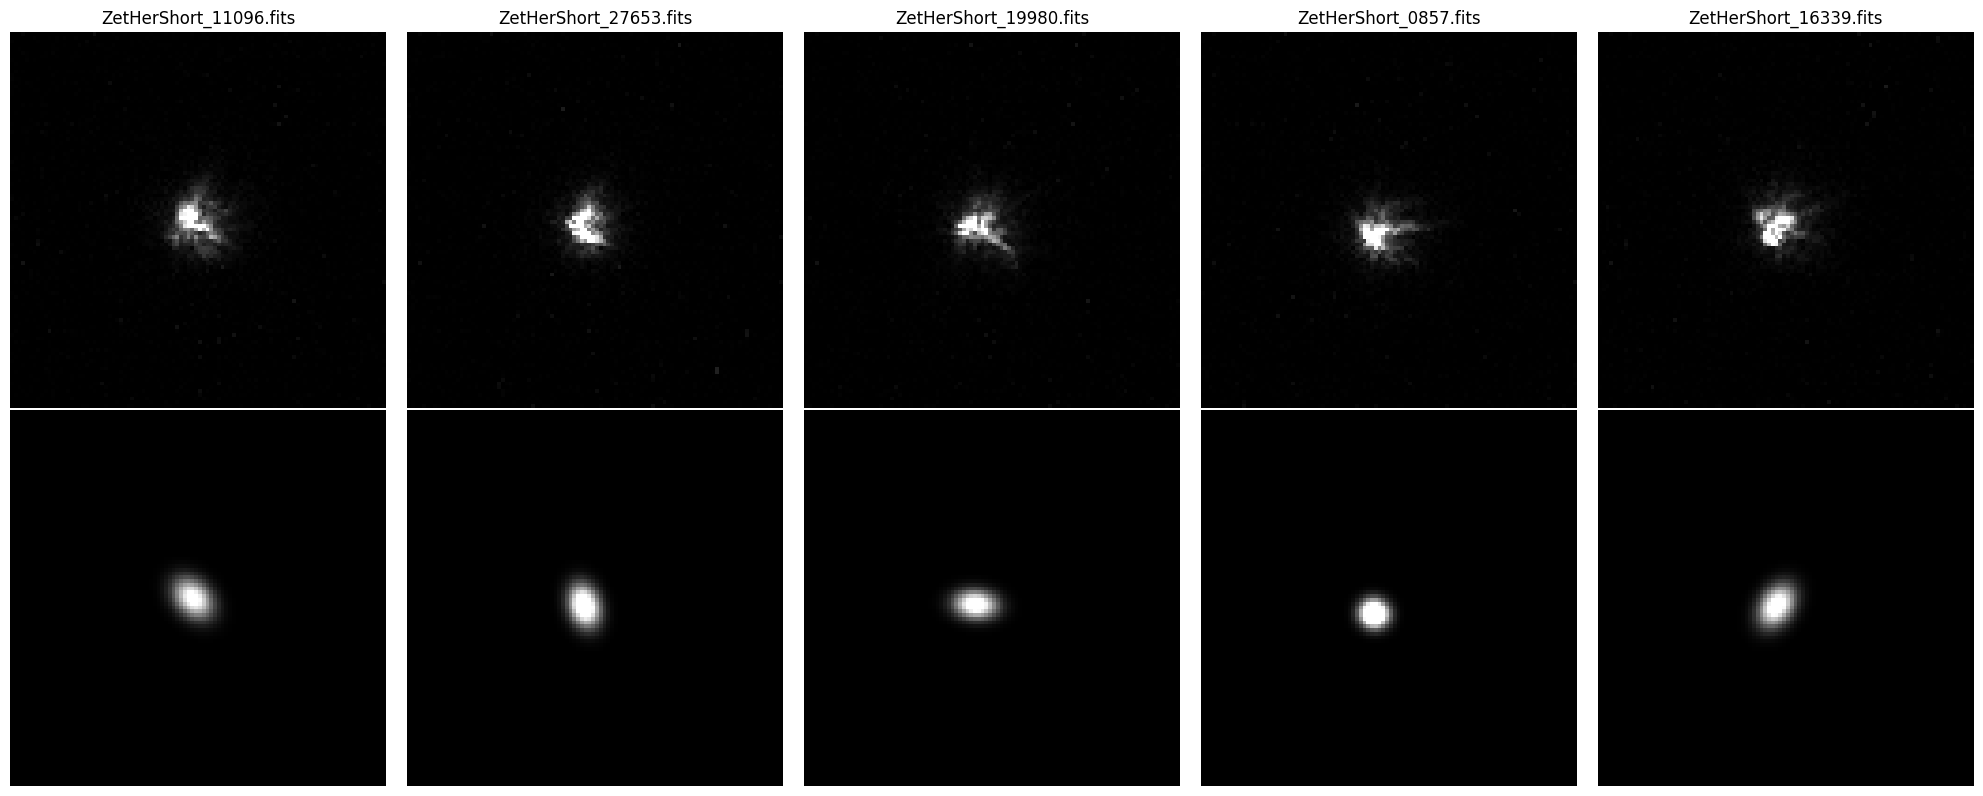

In [28]:
# Display some images with the fitted Gaussian (requires the p_fits array)
if not keepFit:
    print('Fits not saved, cannot display images.')
else:
    indices = np.random.choice(len(data), 5, replace=False)

    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    maxval = 0.3*np.max(data[indices])
    for i, ax in enumerate(np.transpose(axs)):
        ax[0].imshow(data[indices[i]], cmap='gray', vmin=1, vmax=maxval)
        x, y = np.meshgrid(np.arange(data[indices[i]].shape[1]), np.arange(data[indices[i]].shape[0]))
        fit = models.Gaussian2D(amplitude=p_fits[indices[i]].amplitude.value, x_mean=p_fits[indices[i]].x_mean.value, y_mean=p_fits[indices[i]].y_mean.value, x_stddev=p_fits[indices[i]].x_stddev.value, y_stddev=p_fits[indices[i]].y_stddev.value, theta=p_fits[indices[i]].theta.value)
        ax[1].imshow(fit(x, y), cmap='gray', vmin=1, vmax=maxval)
        ax[0].set_title(datafiles[indices[i]])
        ax[0].axis('off')
        ax[1].axis('off')
    plt.tight_layout()
    #plt.savefig('../Results/ZetHer-fits-examples.pdf', format='pdf') #Option to save the figure (included in report)
    plt.show()
    del x, y, fit, maxval, indices, fig, axs, i, ax #Free up memory

In [29]:
def shift_array(arr):
    '''Returns the array shifted so that the maximum value is in the center. Supports multiple dimensions.'''
    
    max_index = np.unravel_index(np.argmax(arr), arr.shape)
    center_index = tuple(dim // 2 for dim in arr.shape)
    shift_amount = tuple(center - max_idx for center, max_idx in zip(center_index, max_index))
    shifted_arr = np.roll(arr, shift_amount, axis=(0, 1))
    return shifted_arr

In [33]:
percentage = 0.05 #Percentage of images to keep, here for testing purposes

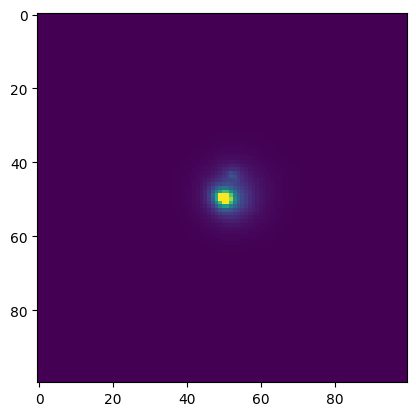

In [38]:
#Select the best percentage% of the data
indices = np.argsort(stddevs)
indices = indices[:int(percentage*len(indices))] #We take the lowest values, as they should correspond to the best data

#Combine the selected data
result = np.zeros(data[0].shape)

shifted_data = ([])
for i in indices:
    shifted_data.append(shift_array(data[i]))
result = np.median(shifted_data, axis=0)

plt.imshow(result, vmax=0.4*np.max(result)) #To increase the contrast


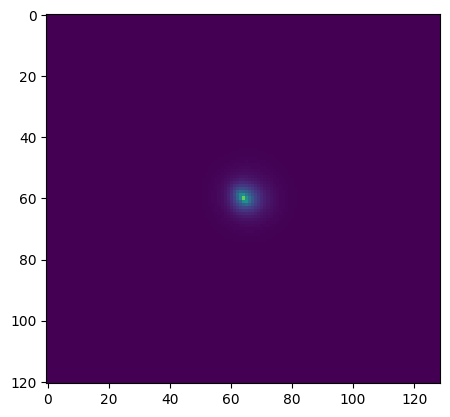

In [15]:
shift_data = np.empty(data.shape)
for i in range(len(data)):
    shift_data[i] = shift_array(data[i])
plt.imshow(np.median(shift_data, axis=0), vmax=0.7*np.max(result)) #To compare with the median of all shifted data

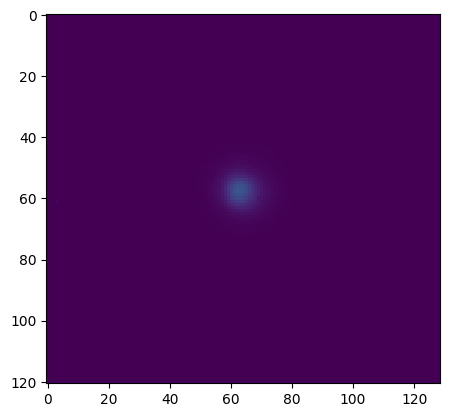

In [16]:
plt.imshow(np.median(data, axis=0), vmax=0.7*np.max(result)) #To compare with the median of all raw (unshifted) data

min: 1.0296992373972842 
 max: 7.5130320582468535
Worst image: ZetHerShort_4336.fits  with index  27080 
 Best image: ZetHerShort_25765.fits  with index  18325


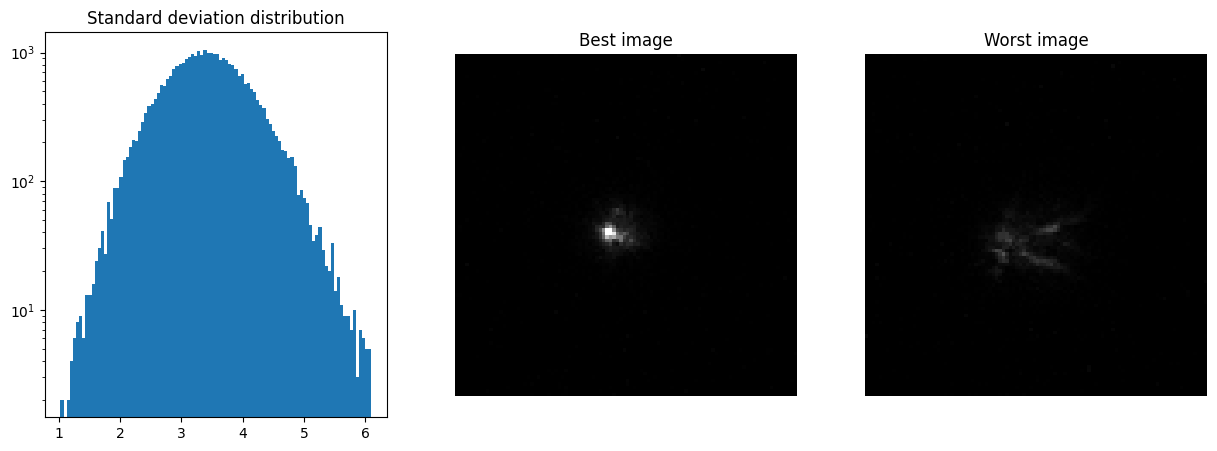

In [31]:
print('min:', np.min(stddevs), '\n max:', np.max(stddevs))
print('Worst image:', datafiles[np.argmin(stddevs)], ' with index ', np.argmin(stddevs), '\n Best image:', datafiles[np.argmax(stddevs)], ' with index ', np.argmax(stddevs))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(np.sort(stddevs)[:-15], bins=100, log=True) #NOTE: the last 5 values are excluded to improve the histogram, since these are mostly fit failures
axs[0].set_title('Standard deviation distribution')
axs[1].imshow(data[np.argmin(stddevs)], cmap='gray', vmax=0.7*np.max(result))
axs[1].set_title('Best image')
axs[1].axis('off')
axs[2].imshow(data[np.argmax(stddevs)], cmap='gray', vmax=0.7*np.max(result))
axs[2].set_title('Worst image')
axs[2].axis('off')
plt.show()

In [43]:
#Calculate the results for the plot
percentages = [0.01, 0.05, 0.1, 0.5]

results = np.zeros((len(percentages) + 2)) #+2 for the median of all data and the median of all shifted data

#Percentages fit
for i, percentage in enumerate(percentages):
    indices = np.argsort(stddevs)
    indices = indices[:int(percentage*len(indices))]
    result = np.zeros(data[0].shape)
    shifted_data = ([])
    for j in indices:
        shifted_data.append(shift_array(data[j]))
    result = np.median(shifted_data, axis=0)
    results[i] = fit_stddev(model, fitter, result)[0]

#All data, shifted and not
results[-2] = fit_stddev(model, fitter, np.median(shift_data, axis=0))[0]
results[-1] = fit_stddev(model, fitter, np.median(data, axis=0))[0]

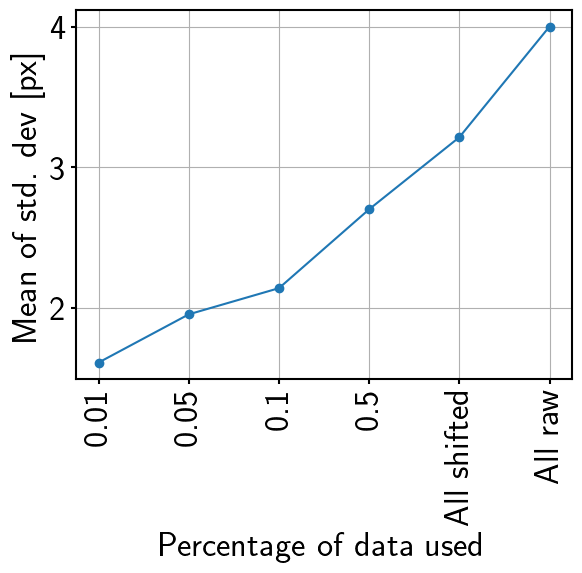

In [56]:
#Plot the results
plt.plot(percentages + ['All shifted', 'All raw'], results, '-o')
plt.tick_params(axis='x', labelrotation=90)
plt.xlabel('Percentage of data used')
plt.ylabel('Mean of std. dev. [px]')
plt.grid()
plt.show()

TODO: add a fit of long exposures and theoretical limit